#Day 1

In [72]:
# notebooks/eda.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Load dataset
df = pd.read_csv('/content/loan_data.csv')
print("Shape:", df.shape)
df.head()


Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [73]:
# Missing value check
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


,0
Credit_History,50
Self_Employed,32
LoanAmount,22
Dependents,15
Loan_Amount_Term,14
Gender,13
Married,3


In [74]:
# Fill categorical with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill numerical with median for LoanAmount and mode for Loan_Amount_Term and Credit_History
df.fillna(df['LoanAmount'].median(), inplace=True)
df.fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df.fillna(df['Credit_History'].mode()[0], inplace=True)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,337.120521,11.197068
std,6109.041673,2926.248369,84.107233,71.874064,34.807678
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,128.000000


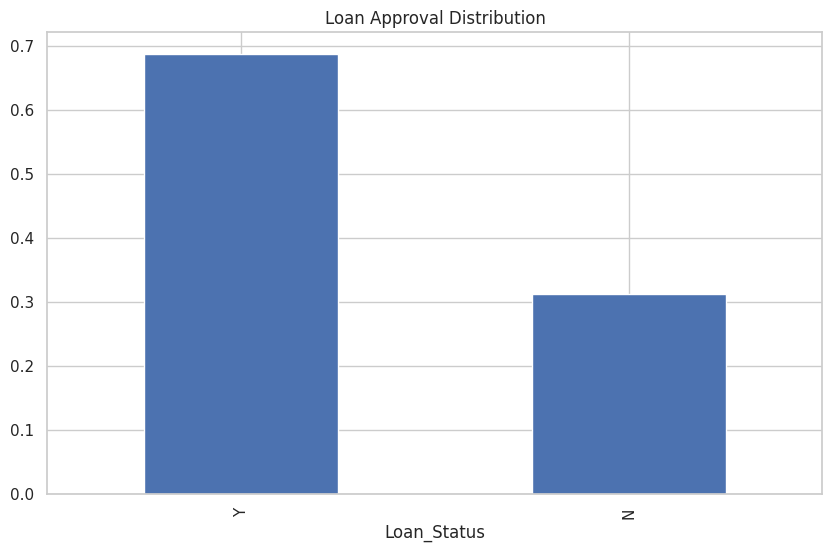

In [75]:
# Class distribution
df['Loan_Status'].value_counts(normalize=True).plot(kind='bar', title='Loan Approval Distribution')

# Summary stats
df.describe()


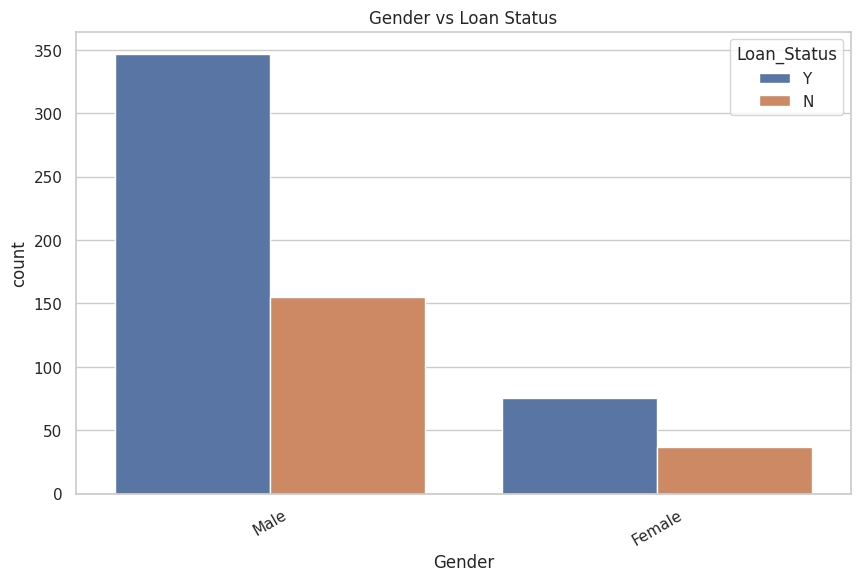

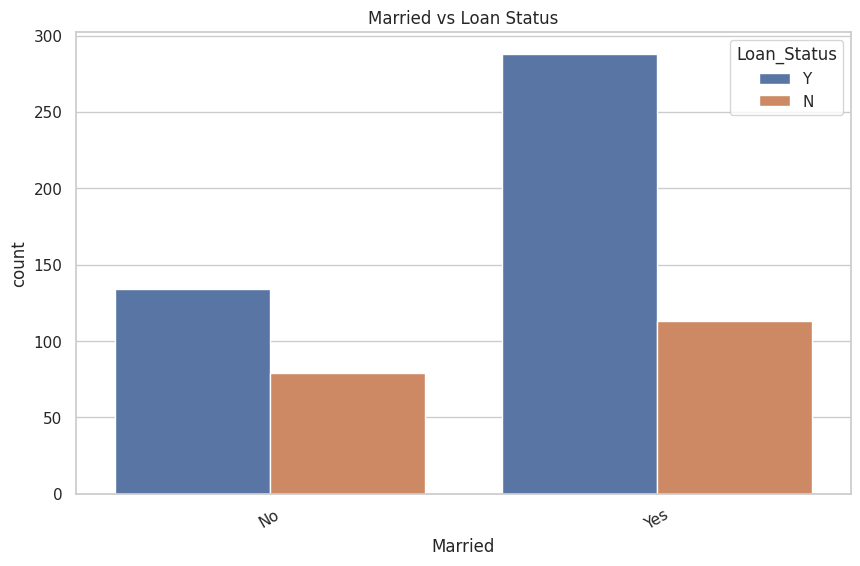

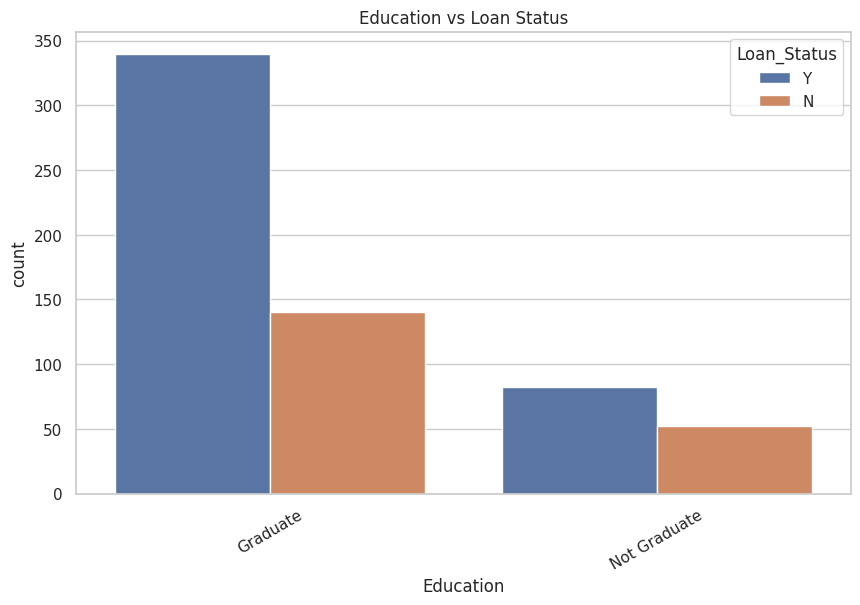

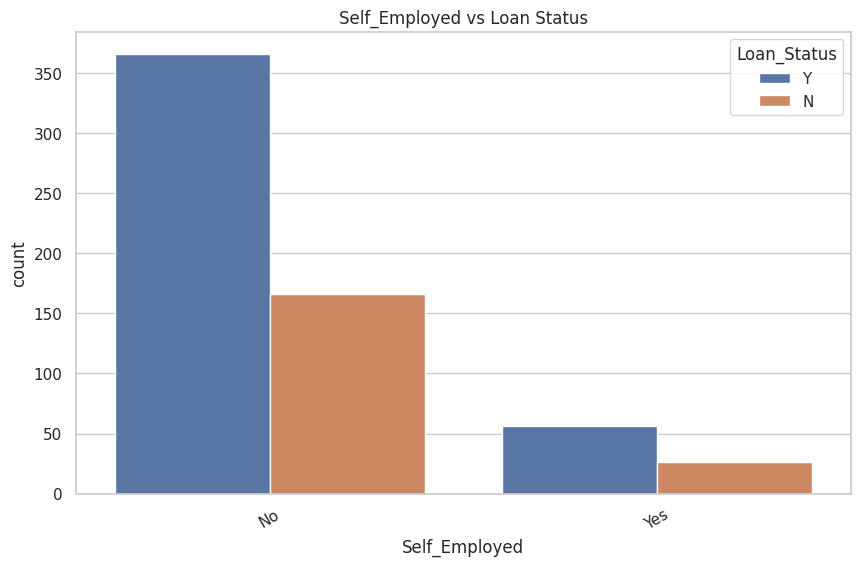

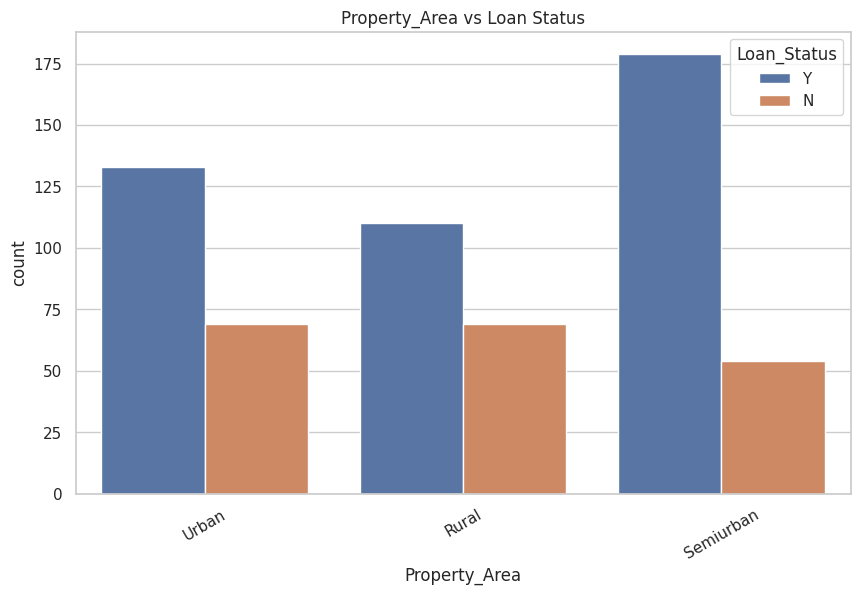

In [49]:
cat_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

for col in cat_features:
    sns.countplot(data=df, x=col, hue='Loan_Status')
    plt.title(f"{col} vs Loan Status")
    plt.xticks(rotation=30)
    plt.show()


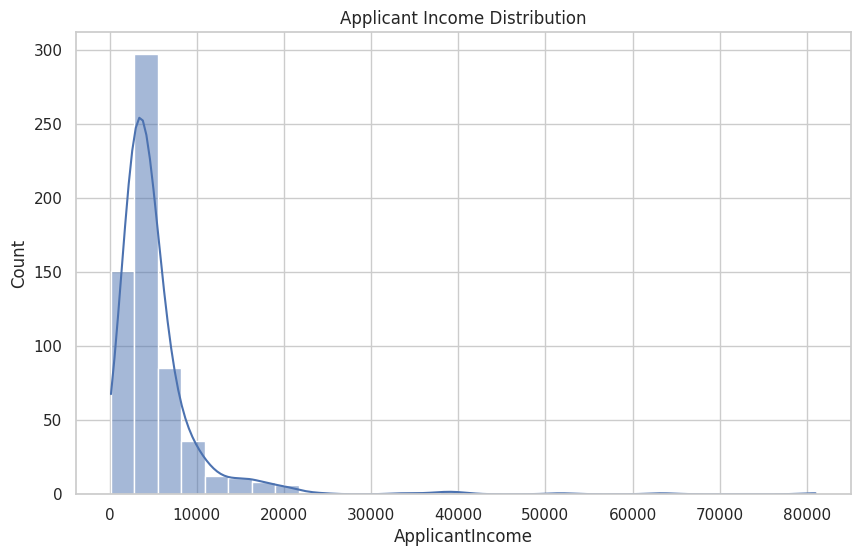

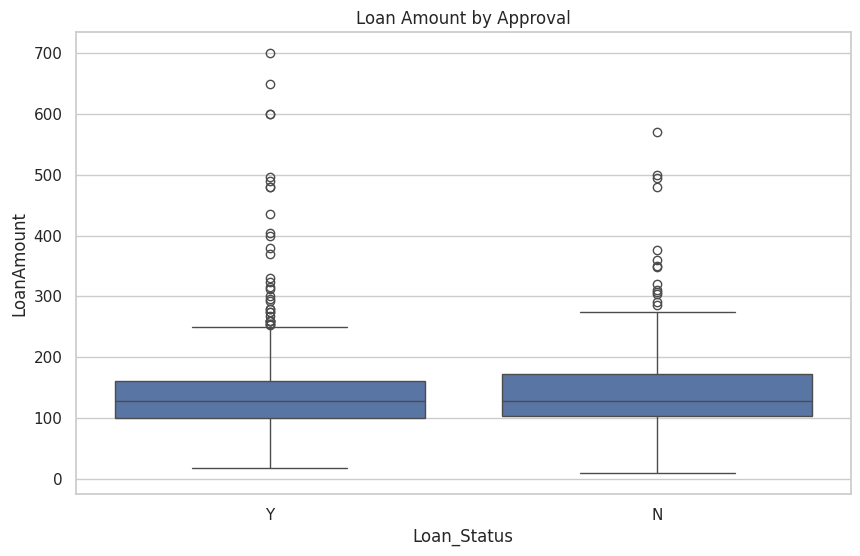

In [50]:
sns.histplot(df['ApplicantIncome'], kde=True, bins=30)
plt.title("Applicant Income Distribution")
plt.show()

sns.boxplot(x='Loan_Status', y='LoanAmount', data=df)
plt.title("Loan Amount by Approval")
plt.show()


In [77]:
# Convert target to binary
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
df['Loan_Status'] = df['Loan_Status'].astype('Int64')
# print(df['Loan_Status'])
# Save cleaned dataset
df.to_csv('../content/loan_clean.csv', index=False)

df_check = pd.read_csv('../content/loan_clean.csv')
print(df_check['Loan_Status'].unique())


[1 0]


#Day 2

In [78]:
# notebooks/model_training.ipynb

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

# Load cleaned data
df = pd.read_csv('/content/loan_clean.csv')
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [95]:
X = df.drop(columns=['Loan_ID','Loan_Status'], axis=1)
y = df['Loan_Status']

In [96]:
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical:", cat_features)
print("Numerical:", num_features)


Categorical: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
Numerical: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [97]:
# OneHotEncoder for categorical, StandardScaler for numerical
cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine into column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


In [98]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])


In [99]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

,0


In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Married',
                                                   'Dependents', 'Education',
                                                   'Self_Employed',
                                                   'Property_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [101]:
y_pred = model_pipeline.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[23 15]
 [ 8 77]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        38
           1       0.84      0.91      0.87        85

    accuracy                           0.81       123
   macro avg       0.79      0.76      0.77       123
weighted avg       0.81      0.81      0.81       123



In [102]:
# Create models/ folder
os.makedirs('../content/models', exist_ok=True)

# Save the full pipeline (includes preprocessor + model)
joblib.dump(model_pipeline, '../content/models/model.pkl')

# Save only the preprocessor if needed separately
joblib.dump(preprocessor, '../content/models/preprocessor.pkl')

print("✅ Model and preprocessor saved.")


✅ Model and preprocessor saved.


# Day 3

In [88]:
pip install shap


In [89]:
# notebooks/explainability.ipynb

import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load model pipeline
model_pipeline = joblib.load('../content/models/model.pkl')

# Load cleaned dataset
df = pd.read_csv('../content/loan_clean.csv')

# Split data again (same as Day 2 to get test set)
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


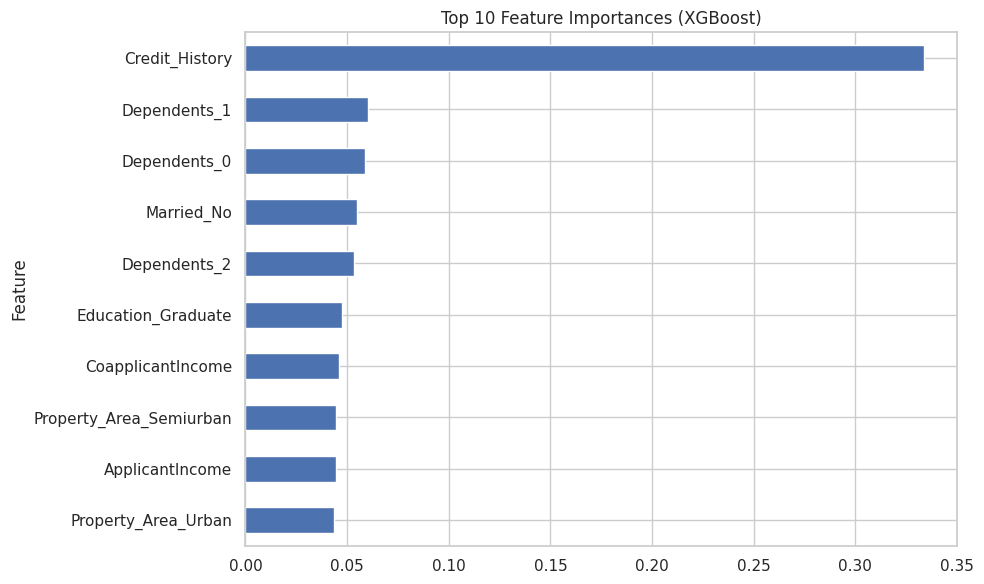

In [90]:
# Extract trained XGBoost model from pipeline
xgb_model = model_pipeline.named_steps['classifier']

# Get feature names after preprocessing
preprocessor = model_pipeline.named_steps['preprocessor']
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get transformed feature names
ohe = preprocessor.named_transformers_['cat']['ohe']
ohe_feature_names = ohe.get_feature_names_out(cat_features)

feature_names = np.concatenate([num_features, ohe_feature_names])

# Plot feature importance
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp_df.head(10).plot.barh(x='Feature', y='Importance', legend=False)
plt.title('Top 10 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


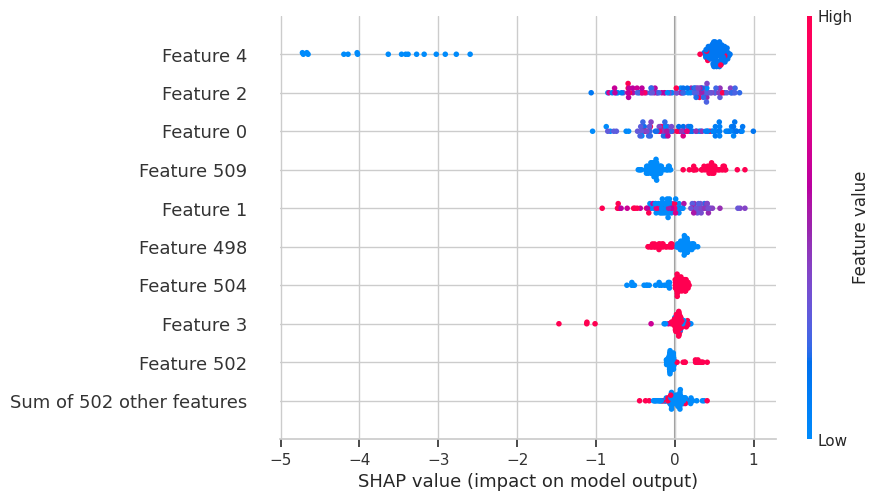

In [91]:
# Only use XGBoost model for SHAP (not full pipeline)
explainer = shap.Explainer(xgb_model)
X_transformed = preprocessor.transform(X_test)

# Compute SHAP values for a sample (faster)
shap_values = explainer(X_transformed[:100])

# Summary plot
shap.plots.beeswarm(shap_values)


In [92]:
# Use the first test instance
shap.initjs()
shap.plots.force(shap_values[0])


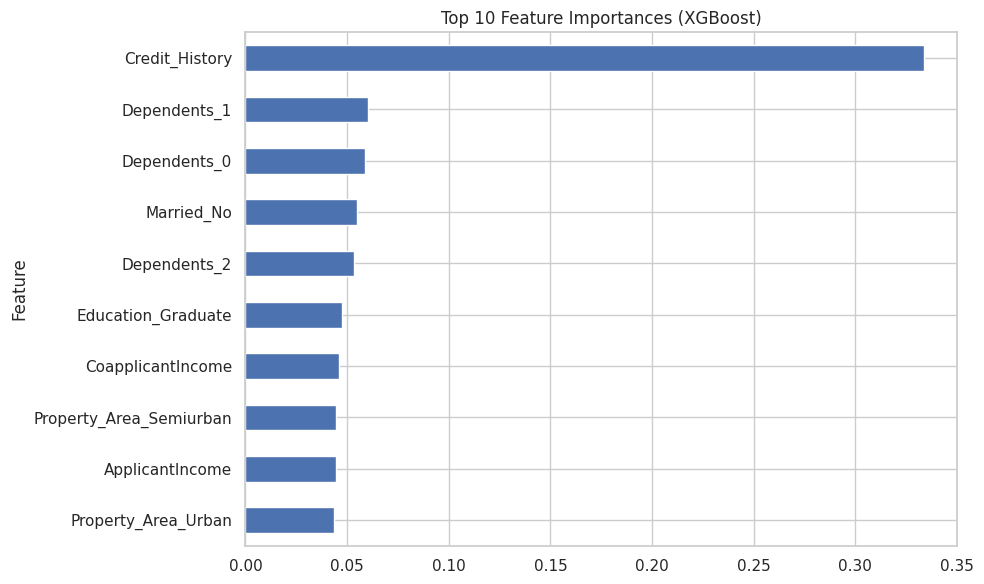

In [94]:
# Save bar plot
feat_imp_df.head(10).plot.barh(x='Feature', y='Importance', legend=False)
plt.title('Top 10 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../content/models/feature_importance.png')
